# IMU-Based Motion Reconstruction of a Mobile Robot  
### *Using XSens MTi-630 IMU Data (10 Hz)*

This notebook reconstructs the **approximate motion trajectory** of a robot using IMU measurements recorded inside the **CLC building**.  
Two datasets are provided:

- **Dataset 1** – short manoeuvre: the robot started from rest, accelerated briefly, moved at (approximately) constant speed, then decelerated to a stop, reversed, and finally stopped again close to its original position.  
- **Dataset 2** – long run with multiple stops and direction changes

Both were recorded using an **XSens MTi-630 IMU** mounted on the robot.

---

## Objective

Using only IMU data (accelerometer, gyroscope, magnetometer), we estimate:

1. **Orientation** (quaternions -> Euler angles)  
2. **Linear acceleration in world frame**  
3. **Velocity** using integration with **Zero-Velocity Updates (ZUPT)**  
4. **Position** using double integration  
5. **2D path of the robot**  

---

**Author:** Priyam Gupta                
**Neptun Code:** KXHGEA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ahrs.filters import Madgwick
from scipy.spatial.transform import Rotation as R
from io import StringIO

## Loading XSens MTi-630 IMU Data

The XSens log files contain a mix of comment lines (starting with `//`) and data lines.  
This function:

1. Reads the text file
2. Removes comment/meta-information lines
3. Converts the remaining CSV-formatted numeric data into a pandas DataFrame
4. Returns the cleaned DataFrame for further IMU processing

This ensures that only valid measurement samples (Acc, Gyr, Mag, SampleTimeFine, etc.) are loaded.

In [2]:
def load_xsens_data(file_path):
    '''
        Load an XSens MTi-630 IMU log file and return its sensor data.

        Arguments:
            file_path: str - Path to the XSens log file.
        
        Returns:
                df : pandas.DataFrame
                DataFrame containing numerical IMU measurements, including:
                    Acc_X, Acc_Y, Acc_Z,
                    Gyr_X, Gyr_Y, Gyr_Z,
                    Mag_X, Mag_Y, Mag_Z,
                    SampleTimeFine
    '''
    # Read all lines from the file
    raw_lines = open(file_path).read().splitlines()

    # Keep only measurement rows (XSens marks metadata with "//")
    data_lines = [line for line in raw_lines if not line.startswith("//")]

    print(f"Loaded XSens sensor data from: {file_path}")

    # Convert the filtered CSV lines into a pandas DataFrame
    df = pd.read_csv(StringIO("\n".join(data_lines)))
    
    return df

In [4]:
# Load the XSens IMU data - Dataset 1
df1 = load_xsens_data('imu_data/xsens_mti_630_imu_first.txt')
df1.head()

print(f"df1 datasize: {df1.shape}")

Loaded XSens sensor data from: imu_data/xsens_mti_630_imu_first.txt
df1 datasize: (426, 11)


In [5]:
# Load the XSens IMU data - Dataset 2
df2 = load_xsens_data('imu_data/xsens_mti_630_imu_second.txt')
df2.head()

print(f"df2 datasize: {df2.shape}")

Loaded XSens sensor data from: imu_data/xsens_mti_630_imu_second.txt
df2 datasize: (1757, 11)


## IMU Timestamp Processing and Sensor data extraction

The XSens MTi-630 provides timestamps in microseconds (`SampleTimeFine`) along with
raw accelerometer, gyroscope, and magnetometer measurements.

This function:

1. Converts XSens microsecond timestamps to seconds  
2. Computes the sampling interval `dt` and approximate sampling frequency  
3. Extracts raw accelerometer, gyro, and magnetometer arrays  
4. Converts gyroscope units from deg/s → rad/s  
5. Prints basic statistics for quick sanity checks

In [13]:
def extract_imu_data(df):
    '''
        Extract IMU data from the XSens DataFrame.

        Arguments:
            df : pandas.DataFrame - DataFrame containing XSens IMU measurements.

        Returns:
            - t : np.ndarray - Timestamps in seconds.
            - dt : np.ndarray - Time differences between samples in seconds.
            - acc : np.ndarray - Accelerometer data in m/s².
            - gyr : np.ndarray - Gyroscope data in rad/s.
            - mag : np.ndarray - Magnetometer data in µT.
            - sample_freq : float - Estimated sampling frequency in Hz.                
    '''
    # Convert XSens microsecond timestamps to seconds (relative time)
    timestamp_us = df["SampleTimeFine"].values.astype(float)
    t = (timestamp_us - timestamp_us[0]) * 1e-4         # microseconds => 0.1ms => seconds
    
    # Time step between samples
    dt = np.diff(t, prepend=t[0])

    # Estimate sampling frequency
    sample_freq = 1/np.mean(dt)

    print("\nIMU dataset info:")
    print(f"Sampling rate = {sample_freq:.2f} Hz")
    print(f"Time span: {t[0]:.3f} s to {t[-1]:.3f} s")

    # Extract raw sensor data
    acc = df[["Acc_X", "Acc_Y", "Acc_Z"]].values
    gyr = df[["Gyr_X", "Gyr_Y", "Gyr_Z"]].values
    mag = df[["Mag_X", "Mag_Y", "Mag_Z"]].values

    # Covert Gyro deg/s to rad/s
    gyr = np.deg2rad(gyr)

    print("\nAccelerometer mean = ", np.mean(acc, axis=0))
    print("Gyroscope mean (rad/s) = ", np.mean(gyr, axis=0))
    print("Magnetometer mean = ", np.mean(mag, axis=0))

    return t, dt, acc, gyr, mag, sample_freq


In [14]:
# Process first dataset
t1, dt1, acc1, gyr1, mag1, sample_freq1 = extract_imu_data(df1)


IMU dataset info:
Sampling rate = 10.02 Hz
Time span: 0.000 s to 42.500 s

Accelerometer mean =  [0.13693501 0.19427858 9.88900275]
Gyroscope mean (rad/s) =  [-5.36727257e-05 -4.41437196e-06  6.47603600e-05]
Magnetometer mean =  [-0.30193784 -0.27457298 -1.43699709]


In [15]:
# Process second dataset
t2, dt2, acc2, gyr2, mag2, sample_freq2 = extract_imu_data(df2)


IMU dataset info:
Sampling rate = 10.01 Hz
Time span: 0.000 s to 175.601 s

Accelerometer mean =  [0.05075041 0.15665663 9.8113698 ]
Gyroscope mean (rad/s) =  [-4.91730474e-05 -1.52042316e-06 -5.97484662e-04]
Magnetometer mean =  [-0.00518384 -0.33748838 -1.2288992 ]


## Sensor Bias Estimation (Accelerometer, Gyroscope, Magnetometer)

During the first few seconds of the dataset, the robot is assumed to be stationary.      

This allows us to estimate:
- Accelerometer bias (constant offset in $\text{m/s}^2$)
- Gyroscope bias (constant angular rate offset in rad/s)
- Magnetometer bias

These biases are subtracted from all samples to produce zero-mean corrected IMU signals, which is essential before performing orientation estimation or integration.

In [18]:
def estimate_sensor_bias(time_s, acc_data, gyr_data, mag_data, stationary_time=2.0):
    '''
        Estimate sensor biases from stationary data.

        Arguments:
            - time_s : np.ndarray - Timestamps in seconds.
            - acc_data : np.ndarray - Accelerometer data in m/s².
            - gyr_data : np.ndarray - Gyroscope data in rad/s.
            - mag_data : np.ndarray - Magnetometer data in µT.
            - stationary_time : float - Duration in seconds to consider as stationary for bias estimation.

        Returns:
            - acc_bias : np.ndarray - Mean accelerometer offset during stationary period.
            - gyr_bias : np.ndarray - Mean gyroscope bias during stationary period.
            - mag_bias : np.ndarray - Mean magnetometer bias during stationary period.
    '''
    # Identify indices corresponding to the first 'stationary_time' seconds
    stationary_idx = np.where(time_s < stationary_time)[0]

    acc_bias = np.mean(acc_data[stationary_idx], axis=0)
    gyr_bias = np.mean(gyr_data[stationary_idx], axis=0)
    mag_bias = np.mean(mag_data[stationary_idx], axis=0)

    return acc_bias, gyr_bias, mag_bias

Dataset 1: ACC Bias: [0.3687131  0.1426306  9.80494365]
Dataset 1: GYR Bias: [-4.22867098e-05 -2.96007841e-06  3.04097442e-05]
Dataset 1: MAG Bias: [-0.3731742  -0.26382095 -1.31537245]


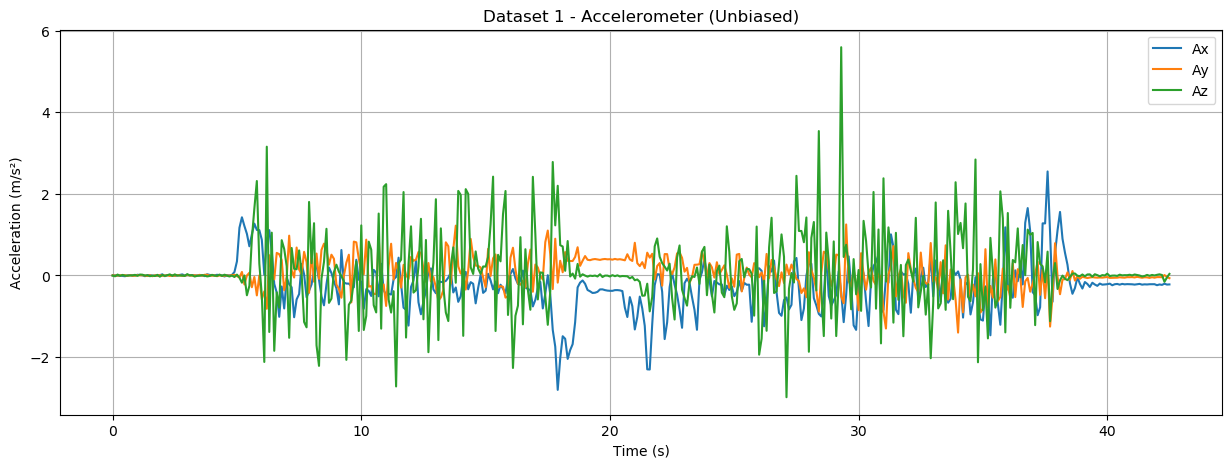

In [19]:
# Estimate biases for dataset 1
acc_bias1, gyr_bias1, mag_bias1 = estimate_sensor_bias(t1, acc1, gyr1, mag1)

print("Dataset 1: ACC Bias:", acc_bias1)
print("Dataset 1: GYR Bias:", gyr_bias1)
print("Dataset 1: MAG Bias:", mag_bias1)

# Remove estimated biases
acc1_unbiased = acc1 - acc_bias1
gyr1_unbiased = gyr1 - gyr_bias1
mag1_unbiased = mag1 - mag_bias1

plt.figure(figsize=(15,5))
plt.plot(t1, acc1_unbiased)
plt.title("Dataset 1 - Accelerometer (Unbiased)")
plt.legend(["Ax","Ay","Az"])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.grid()
plt.show()

Dataset 2: ACC Bias: [-0.03900635  0.1698635   9.8146436 ]
Dataset 2: GYR Bias: [-3.33541147e-05  8.19083018e-06  3.62277993e-05]
Dataset 2: MAG Bias: [-0.24450285 -0.189974   -1.341523  ]


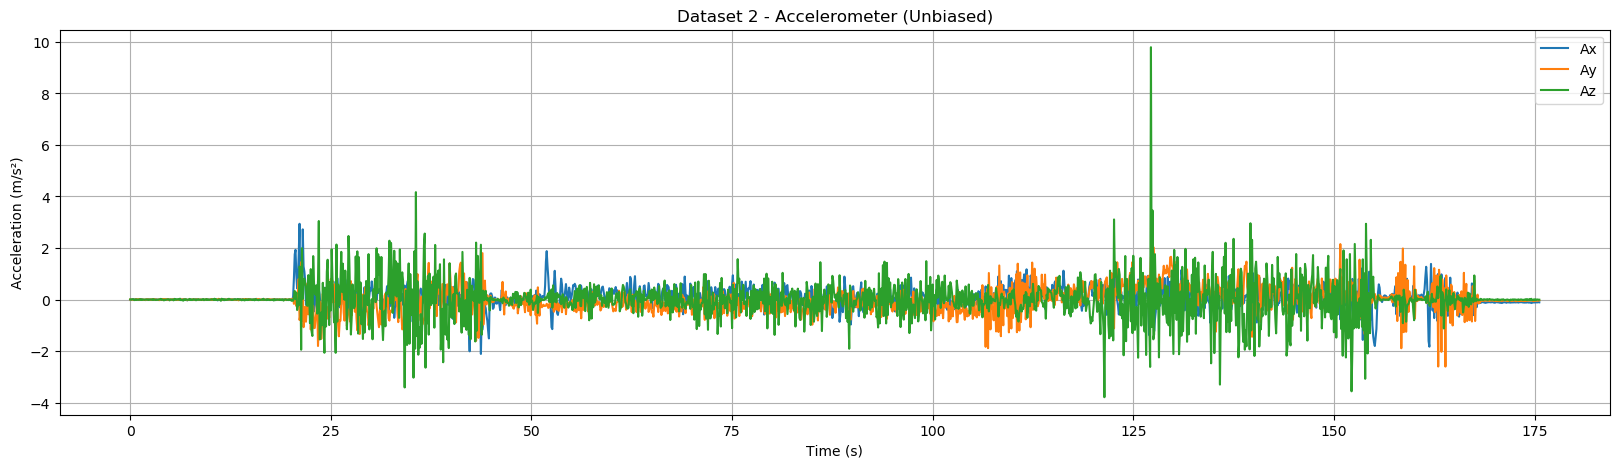

In [21]:
# Estimate biases for dataset 2
acc_bias2, gyr_bias2, mag_bias2 = estimate_sensor_bias(t2, acc2, gyr2, mag2)

print("Dataset 2: ACC Bias:", acc_bias2)
print("Dataset 2: GYR Bias:", gyr_bias2)
print("Dataset 2: MAG Bias:", mag_bias2)

# Remove estimated biases
acc2_unbiased = acc2 - acc_bias2
gyr2_unbiased = gyr2 - gyr_bias2
mag2_unbiased = mag2 - mag_bias2

plt.figure(figsize=(20,5))
plt.plot(t2, acc2_unbiased)
plt.title("Dataset 2 - Accelerometer (Unbiased)")
plt.legend(["Ax","Ay","Az"])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.grid()
plt.show()

## ENU -> NED Conversion and Orientation Estimation (Madgwick Filter)

The XSens MTi-630 provides IMU measurements in the **ENU (East-North-Up)** coordinate frame.          
However, the Madgwick filter and many robotics applications use **NED (North-East-Down)**.

This section performs:

1. Frame conversion **(ENU to NED)** for accelerometer, gyro, and magnetometer.
2. 9-DoF Madgwick orientation estimation, producing a quaternion at each timestep.
3. Quaternion logging and progress printing for debugging.

The output is a sequence of **body to world quaternion** which will be used to rotate IMU accelerations into the world frame.

In [23]:
def convert_enu_to_ned(vec_enu):
    '''
        Convert vectors from ENU (East-North-Up) to NED (North-East-Down) coordinate system.

        Arguments:
            vec_enu : np.ndarray - Input vectors in ENU format (shape: Nx3).

        Returns:
            np.ndarray - Converted vectors in NED format (shape: Nx3).
    '''
    # ENU to NED mapping
    x_ned = vec_enu[:,1]        #   X_ned =  Y_enu   (North)
    y_ned = vec_enu[:,0]        #   Y_ned =  X_enu   (East)
    z_ned = -vec_enu[:,2]       #   Z_ned = -Z_enu   (Down)

    return np.column_stack((x_ned, y_ned, z_ned))

In [26]:
def run_madgwick_filter(acc_ned, gyr_ned, mag_ned, sample_freq, beta=0.005):
    '''
        Run the 9-DOF Madgwick filter on the provided IMU data to estimate orientation quaternions.

        Arguments:
            - acc_ned : np.ndarray - Accelerometer data in NED format (shape: Nx3).
            - gyr_ned : np.ndarray - Gyroscope data in NED format (shape: Nx3).
            - mag_ned : np.ndarray - Magnetometer data in NED format (shape: Nx3).
            - sample_freq : float - Sampling frequency in Hz.
            - beta : float - Madgwick filter gain parameter.

        Returns:
            - quaternions : np.ndarray - Estimated orientation quaternions (shape: Nx4).
    '''
    print(f"Running Madgwick at approx. {sample_freq:.2f} Hz\n")
    madgwick = Madgwick(beta=beta, frequency=sample_freq)

    N = len(acc_ned)                            # Number of samples
    quaternions = np.zeros((N, 4))

    q = np.array([1.0, 0.0, 0.0, 0.0])          # Initial quaternion

    for i in range(N):
        q = madgwick.updateMARG(q, gyr_ned[i], acc_ned[i], mag_ned[i])
        quaternions[i] = q

    print("Madgwick filtering complete.")
    print("Final quaternion norm:", np.linalg.norm(quaternions[-1]))

    return quaternions

In [27]:
# Convert Dataset 1 from ENU to NED
acc1_ned = convert_enu_to_ned(acc1_unbiased)
gyr1_ned = convert_enu_to_ned(gyr1_unbiased)
mag1_ned = convert_enu_to_ned(mag1_unbiased)

print("\nConverted ENU -> NED for Dataset 1.")

# Run Madgwick orientation filter on Dataset 1
quaternions1_9d = run_madgwick_filter(acc1_ned, gyr1_ned, mag1_ned, sample_freq1)


Converted ENU -> NED for Dataset 1.
Running Madgwick at approx. 10.02 Hz

Madgwick filtering complete.
Final quaternion norm: 1.0


In [28]:
# Convert Dataset 2 from ENU to NED
acc2_ned = convert_enu_to_ned(acc2_unbiased)
gyr2_ned = convert_enu_to_ned(gyr2_unbiased)
mag2_ned = convert_enu_to_ned(mag2_unbiased)

print("\nConverted ENU -> NED for Dataset 2.")

# Run Madgwick orientation filter on Dataset 2
quaternions2_9d = run_madgwick_filter(acc2_ned, gyr2_ned, mag2_ned, sample_freq2)


Converted ENU -> NED for Dataset 2.
Running Madgwick at approx. 10.01 Hz

Madgwick filtering complete.
Final quaternion norm: 0.9999999999999999


## Quaternion Validation and Euler Angle Extraction

After running the Madgwick filter, we obtain a quaternion orientation estimate for every IMU sample.

This section performs three key steps:
1. **Quaternion Norm Check** - Ensures numerical stability by verifying all quaternions remain unit-length.
2. **Quaternion -> Euler Angle Conversion** - Converts NED-frame quaternions into ENU-frame Euler angles (Roll, Pitch, Yaw), including correct NED -> ENU rotation handling.
3. **Euler Angle Visualization** - Plots the full orientation time series for each dataset.

In [29]:
# Compute quaternion norms
def compute_quaternion_norms(quaternions):
    '''
        Compute the Euclidean norms of each quaternion.

        Arguments:
            quaternions : np.ndarray - Array of quaternions [qw, qx, qy, qz] (shape: Nx4).

        Returns:
            np.ndarray - Array of quaternion norms (shape: N,).
    '''
    norms = np.linalg.norm(quaternions, axis=1)
    return norms


def quaternions_to_euler_enu(quaternions):
    '''
        Convert NED-frame quaternions into ENU-frame Euler angles (roll, pitch, yaw).

        Arguments:
            quaternions : np.ndarray - Array of quaternions [qw, qx, qy, qz] (shape: Nx4).

        Returns:
            np.ndarray - Array of Euler angles [roll, pitch, yaw] in degrees (shape: Nx3) in ENU frame.
    '''
    N = len(quaternions)                    # Number of samples
    euler_deg = np.zeros((N, 3))

    # Rotation matrix to convert NED to ENU
    T = np.array([
                    [0, 1, 0],
                    [1, 0, 0],
                    [0, 0, -1]
                ])

    for i in range(N):
        # SciPy expects quaternions in [x, y, z, w] order
        q_xyzw = [quaternions[i, 1], quaternions[i, 2],
                  quaternions[i, 3], quaternions[i, 0]]

        # Convert quaternion to rotation matrix (body to world NED)
        R_ned = R.from_quat(q_xyzw).as_matrix()

        # Convert to ENU frame
        R_enu = T @ R_ned @ T.T

        # Extract Euler angles (XYZ convention)
        euler_deg[i] = R.from_matrix(R_enu).as_euler('xyz', degrees=True)

    # Unwrap yaw angle to remove jumps at +/-180°
    euler_deg[:, 2] = np.rad2deg(np.unwrap(np.deg2rad(euler_deg[:, 2])))

    return euler_deg

# Plot Euler angles
def plot_euler_angles(t, eulers, title="Euler Angles"):
    '''
        Plot Euler angles (roll, pitch, yaw) over time.
    '''
    plt.figure(figsize=(15,5))
    plt.plot(t, eulers)
    plt.title(title)
    plt.legend(["Roll (X)","Pitch (Y)","Yaw (Z)"])
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.grid()
    plt.show()

In [30]:
# Quaternion Norm Diagnostics
norms1 = compute_quaternion_norms(quaternions1_9d)
print("\nDataset 1 Quaternion Norms: mean:", norms1.mean(), "| std:", norms1.std())
print("Min:", norms1.min(), "| Max:", norms1.max())

norms2 = compute_quaternion_norms(quaternions2_9d)
print("\nDataset 2 Quaternion Norms: mean:", norms2.mean(), "| std:", norms2.std())
print("Min:", norms2.min(), "| Max:", norms2.max())


Dataset 1 Quaternion Norms: mean: 1.0 | std: 8.487994779946639e-17
Min: 0.9999999999999998 | Max: 1.0000000000000002

Dataset 2 Quaternion Norms: mean: 1.0 | std: 8.354796755901953e-17
Min: 0.9999999999999998 | Max: 1.0000000000000002


In [31]:
# Convert Quaternions to Euler angles
eulers1 = quaternions_to_euler_enu(quaternions1_9d)
print("\nDataset 1 Euler (Roll, Pitch, Yaw)\nMean:", np.mean(eulers1, axis=0),
      "\nStd:", np.std(eulers1, axis=0))

eulers2 = quaternions_to_euler_enu(quaternions2_9d)
print("\nDataset 2 Euler (Roll, Pitch, Yaw)\nMean:", np.mean(eulers2, axis=0),
      "\nStd:", np.std(eulers2, axis=0))


Dataset 1 Euler (Roll, Pitch, Yaw)
Mean: [3.00614634 1.45737294 3.68564676] 
Std: [2.51724806 0.76762627 2.61685502]

Dataset 2 Euler (Roll, Pitch, Yaw)
Mean: [ 8.38324181  5.52399687 15.58572476] 
Std: [ 5.86310401  3.03301928 13.15788409]


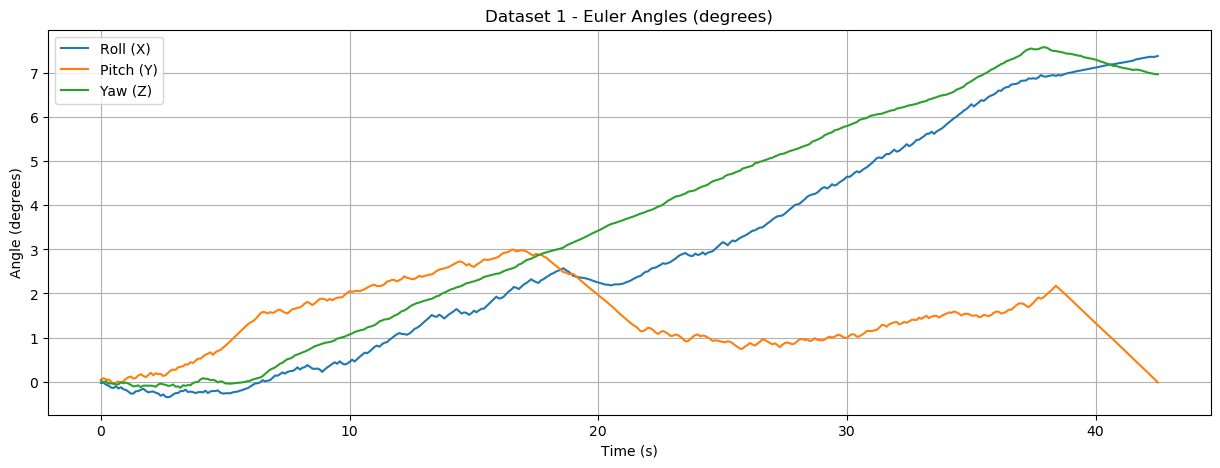

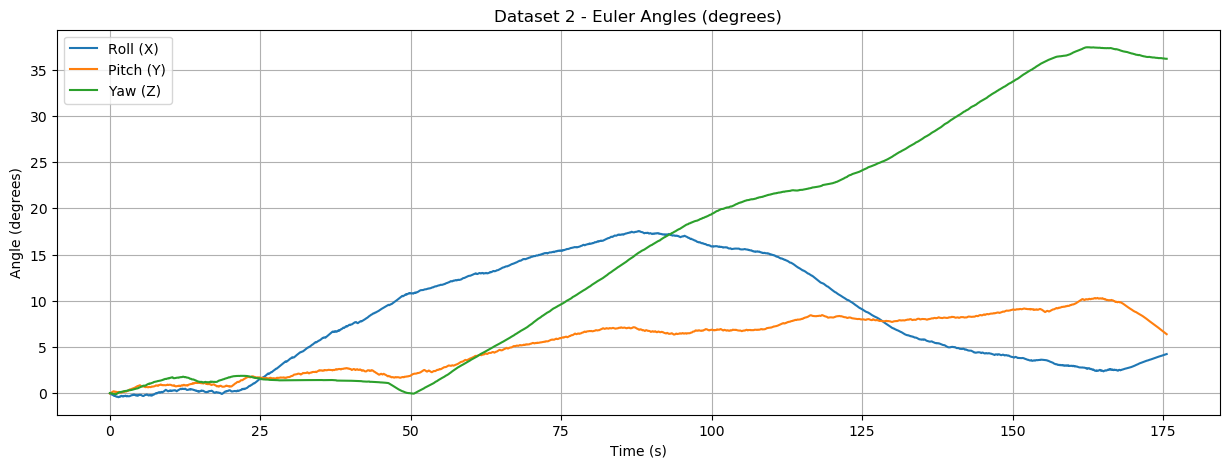

In [32]:
# Plot Euler angles
plot_euler_angles(t1, eulers1, title="Dataset 1 - Euler Angles (degrees)")
plot_euler_angles(t2, eulers2, title="Dataset 2 - Euler Angles (degrees)")

## Transform IMU Acceleration from Body Frame to World (NED) frame.

The Madgwick filter provides orientation of the IMU in the **world NED frame**.  
To compute the robot’s motion, accelerometer readings must be rotated from the  
sensor’s **body coordinate frame** into the **world coordinate frame**.

This cell performs:

1. **Body → World rotation** of accelerometer measurements  
2. Outputs `linacc*_world_ned`, the acceleration used for dead reckoning

In [35]:
def rotate_acc_body_to_world_ned(acc_body_ned, quaternions_ned):
    '''
        Rotate body-frame accelerations to world-frame (NED).

        Arguments:
            acc_body_ned : np.ndarray - Accelerometer data in body frame NED (shape: Nx3).
            quaternions_ned : np.ndarray - Orientation quaternions in NED frame [qw, qx, qy, qz] (shape: Nx4).

        Returns:
            np.ndarray - Accelerations in world frame NED (shape: Nx3).
    '''
    N = len(acc_body_ned)                       # Number of samples
    acc_world_ned = np.zeros_like(acc_body_ned)

    for i in range(N):
        # Convert quaternion [qw,qx,qy,qz] -> scipy format [qx,qy,qz,qw]
        q_xyzw = [quaternions_ned[i,1], 
                  quaternions_ned[i,2],
                  quaternions_ned[i,3],
                  quaternions_ned[i,0]]
        
        # Rotation matrix from body to world (NED)
        R_b2w = R.from_quat(q_xyzw).as_matrix()   

        # Rotate body-frame acceleration to world-frame  
        acc_world_ned[i] = R_b2w @ acc_body_ned[i]

    print("\nExample rotation matrix (last sample):\n", R_b2w)
    return acc_world_ned   

In [37]:
# Rotate raw accelerations into world NED frame
acc1_world_raw = rotate_acc_body_to_world_ned(acc1_ned, quaternions1_9d)
acc2_world_raw = rotate_acc_body_to_world_ned(acc2_ned, quaternions2_9d)

# These are gravity-free accelerations (linear accelerations)
linacc1_world_ned = acc1_world_raw
linacc2_world_ned = acc2_world_raw


Example rotation matrix (last sample):
 [[ 9.84341796e-01  1.21461634e-01  1.27743099e-01]
 [-1.20494027e-01  9.92596073e-01 -1.53044183e-02]
 [-1.28656199e-01 -3.27501903e-04  9.91689203e-01]]

Example rotation matrix (last sample):
 [[ 0.80968968  0.58682833 -0.0059275 ]
 [-0.58227549  0.80206604 -0.13283569]
 [-0.0731975   0.11100712  0.99112035]]


## Stationary Detection (ZUPT Preparation)

To apply Zero-Velocity Updates (ZUPT), the system must know when the robot is  
*not moving*. XSens MTi-630 outputs **linear acceleration without gravity**,  
so stationary periods are detected using:

- **Acceleration magnitude = 0**  
- **Gyroscope magnitude = 0**

This cell:
1. Computes acceleration magnitude and gyro magnitude  
2. Detects stationary samples using thresholds  
3. Prints statistics for debugging  
4. Plots detected stationary intervals 

In [41]:
def detect_stationary_periods(acc_world_ned, gyr_world_ned, acc_threshold=0.2, gyr_threshold=0.05):
    '''
        Detect stationary periods based on accelerometer and gyroscope magnitudes 
        for Zero-Velocity Updates (ZUPT).

        Arguments:
            - acc_world_ned : np.ndarray - Accelerations in world frame NED (shape: Nx3).
            - gyr_world_ned : np.ndarray - Gyroscope data in world frame NED (shape: Nx3).
            - acc_threshold : float - Acceleration magnitude threshold for stationary detection (m/s²).
            - gyr_threshold : float - Gyroscope magnitude threshold for stationary detection (rad/s).

        Returns:
            - stationary : np.ndarray - Boolean array indicating stationary samples (shape: N,).
            - acc_mag : np.ndarray - Accelerometer magnitudes (shape: N,).
            - gyr_mag : np.ndarray - Gyroscope magnitudes (shape: N,).
    '''
    # Compute magnitudes
    acc_magnitude = np.linalg.norm(acc_world_ned, axis=1)
    gyro_magnitude = np.linalg.norm(gyr_world_ned, axis=1)

    # Determine stationary samples = low acc & low gyro
    stationary_mask = (acc_magnitude < acc_threshold) & (gyro_magnitude < gyr_threshold)

    print(f"Detected {stationary_mask.sum()} stationary samples out of {len(stationary_mask)}")
    print(f"Acceleration magnitude: min={acc_magnitude.min():.3f}, max={acc_magnitude.max():.3f}, mean={acc_magnitude.mean():.3f}")
    print(f"Gyroscope magnitude:   min={gyro_magnitude.min():.3f}, max={gyro_magnitude.max():.3f}, mean={gyro_magnitude.mean():.3f}\n")

    return stationary_mask, acc_magnitude, gyro_magnitude

Detected 100 stationary samples out of 426
Acceleration magnitude: min=0.003, max=5.630, mean=0.949
Gyroscope magnitude:   min=0.000, max=0.004, mean=0.001

Detected 444 stationary samples out of 1757
Acceleration magnitude: min=0.002, max=9.958, mean=0.745
Gyroscope magnitude:   min=0.000, max=0.009, mean=0.001


Dataset 1 stationary samples: 100
Dataset 2 stationary samples: 444


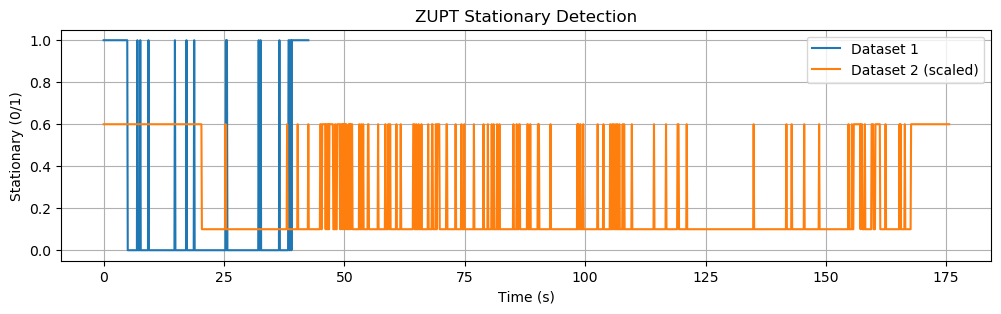

In [42]:
# Detect stationary periods for ZUPT
acc_threshold = 0.3             # m/s²
gyro_threshold = 0.1            # rad/s

# Dataset 1 and Dataset 2
stat_mask1, accmag1, gyrmag1 = detect_stationary_periods(linacc1_world_ned, gyr1_ned, acc_threshold, gyro_threshold)
stat_mask2, accmag2, gyrmag2 = detect_stationary_periods(linacc2_world_ned, gyr2_ned, acc_threshold, gyro_threshold)

print("\nDataset 1 stationary samples:", stat_mask1.sum())
print("Dataset 2 stationary samples:", stat_mask2.sum())

# Plot stationary detection results
plt.figure(figsize=(12,3))
plt.plot(t1, stat_mask1.astype(int), label="Dataset 1")
plt.plot(t2, stat_mask2.astype(int) * 0.5 + 0.1, label="Dataset 2 (scaled)")
plt.title("ZUPT Stationary Detection")
plt.xlabel("Time (s)")
plt.ylabel("Stationary (0/1)")
plt.legend()
plt.grid()
plt.show()

## Velocity & Position Reconstruction (Dead Reckoning with ZUPT)

Once linear acceleration is obtained in the world frame (NED), we reconstruct the
robot's motion using:

1. **Velocity integration**
   - `v[t] = v[t-1] + a[t] * dt`
   - With **Zero-Velocity Updates (ZUPT)** applied at stationary samples.

2. **Position integration**
   - `p[t] = p[t-1] + v[t] * dt`

This method produces:
- Corrected velocity profiles  
- Drift-reduced position estimates  
- Start/stop event behavior  
- Final displacement of the robot  

In [43]:
def integrate_velocity_zupt(acc_world, dt, stationary_mask):
    '''
        Integrate linear accelerations to estimate velocity (NED frame) with
        Zero-Velocity Updates (ZUPT) during stationary periods.

        Arguments:
            - acc_world : np.ndarray - Linear accelerations in world frame NED (shape: Nx3).
            - dt : np.ndarray - Time differences between samples in seconds (shape: N,).
            - stationary_mask : np.ndarray - Boolean array indicating stationary samples (shape: N,).

        Returns:
            - velocity : np.ndarray - Estimated velocities in world frame NED (shape: Nx3).
    '''
    velocity = np.zeros_like(acc_world)

    for i in range(1, len(acc_world)):
        # Integrate acceleration to get velocity
        velocity[i] = velocity[i-1] + acc_world[i] * dt[i]
        
        # Apply zero-velocity update (ZUPT): set velocity to zero if stationary
        if stationary_mask[i]:
            velocity[i] = np.zeros(3)

    return velocity

In [46]:
# Velocity reconstruction with ZUPT
vel1_ned = integrate_velocity_zupt(linacc1_world_ned, dt1, stat_mask1)
print("Dataset 1: mean velocty =", np.mean(vel1_ned, axis=0))

vel2_ned = integrate_velocity_zupt(linacc2_world_ned, dt2, stat_mask2)
print("Dataset 2: mean velocity =", np.mean(vel2_ned, axis=0))

Dataset 1: mean velocty = [ 0.15134632 -0.59764946 -0.09725344]
Dataset 2: mean velocity = [ 0.20922172  0.11070429 -0.02846816]


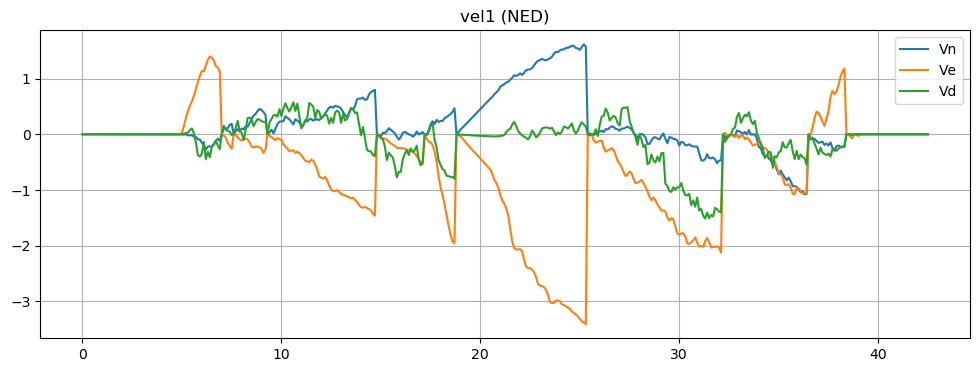

vel1 at stationary indices (mean |v|): [0. 0. 0.]


In [57]:
# Plot velocity time-series for Dataset 1 
plt.figure(figsize=(12,4))
plt.plot(t1, vel1_ned); 
plt.legend(['Vn', 'Ve', 'Vd']); 
plt.title('vel1 (NED)'); 
plt.grid(); 
plt.show()

# Velocities at stationary frames (should be approx. 0)
print("vel1 at stationary indices (mean |v|):", np.mean(np.abs(vel1_ned[stat_mask1]), axis=0))

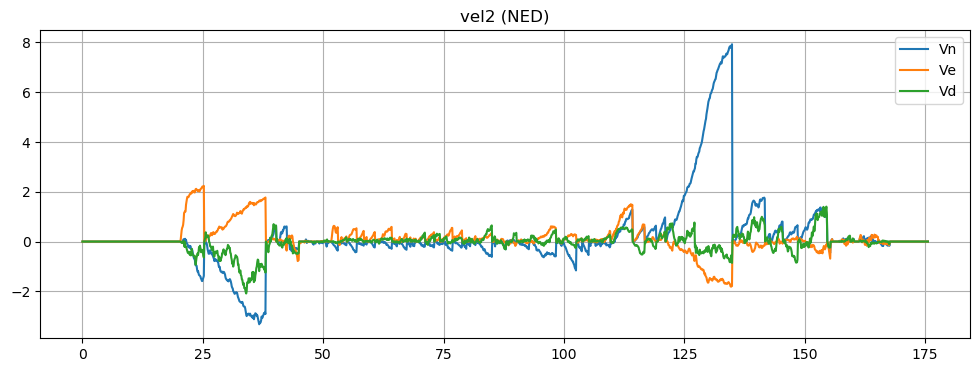

vel2 at stationary indices: mean abs [0. 0. 0.]


In [58]:
# Plot velocity time-series for Dataset 2
plt.figure(figsize=(12,4))
plt.plot(t2, vel2_ned); 
plt.legend(['Vn', 'Ve', 'Vd']); 
plt.title('vel2 (NED)'); 
plt.grid(); 
plt.show()

# Velocities at stationary frames (should be approx. 0)
print("vel2 at stationary indices: mean abs", np.mean(np.abs(vel2_ned[stat_mask2]),axis=0))

In [60]:
def integrate_position_ned(velocity, dt):
    '''
        Integrate velocity in NED frame to obtain robot trajectory (position).

        Arguments:
            - velocity : np.ndarray - Velocity in world frame NED (shape: Nx3).
            - dt : np.ndarray - Time differences between samples in seconds (shape: N,).

        Returns:
            - position : np.ndarray - Estimated positions in world frame NED (shape: Nx3).
    '''
    position = np.zeros_like(velocity)

    for i in range(1, len(velocity)):
        position[i] = position[i-1] + velocity[i] * dt[i]

    return position

In [61]:
# Position reconstruction
pos1_ned = integrate_position_ned(vel1_ned, dt1)
pos2_ned = integrate_position_ned(vel2_ned, dt2)

# Final displacement (last position)
pos1_end = pos1_ned[-1]
pos2_end = pos2_ned[-1]

print("Dataset1: Final displacement:", pos1_end, ", mag = ", np.linalg.norm(pos1_end), "m")
print("Dataset1: Final displacement:", pos2_end, ", mag = ", np.linalg.norm(pos2_end), "m")

Dataset1: Final displacement: [  6.4474222  -25.46000542  -4.14302929] , mag =  26.58845276447477 m
Dataset1: Final displacement: [36.76029244 19.45084241 -5.00187773] , mag =  41.888818931190364 m


## Velocity Drift Correction (Interpolated ZUPT-Based Reset)

Even with ZUPT applied, integrated velocity may still accumulate **slow linear drift**
between stationary intervals.  

To mitigate this, we apply **drift correction**:

1. Identify first and last stationary timestamps  
2. Compute the drift vector between these points  
3. Linearly interpolate drift across the interval  
4. Subtract it from the velocity curve  

This ensures the velocity returns to ~0 at stationary points

In [62]:
def correct_velocity_drift_linear(velocity, stationary_mask):
    '''
        Apply linear drift correction to velocity using stationary intervals.

        Arguments:
            - velocity : np.ndarray - Velocity in world frame NED (shape: Nx3).
            - stationary_mask : np.ndarray - Boolean array indicating stationary samples (shape: N,).

        Returns:
            - vel_corr : np.ndarray - Drift-corrected velocity (shape: Nx3).
    '''
    velocity_corrected = velocity.copy()        # Corrected velocity
    N = len(velocity)                           # Number of samples

    # Find first and last stationary samples
    static_indices = np.where(stationary_mask)[0]
    idx_first = static_indices[0]
    idx_last = static_indices[-1]

    # Drift vector = difference between velocities at stationary points
    drift_vec = velocity[idx_last] - velocity[idx_first]

    # Spread drift linearly across interval
    frames = idx_last - idx_first + 1
    drift_per_step = drift_vec / frames

    # Apply correction to each step
    for i in range(idx_first, idx_last + 1):
        velocity_corrected[i] -= (i - idx_first) * drift_per_step

    return velocity_corrected

In [63]:
# Apply drift correction to both datasets
vel1_corr = correct_velocity_drift_linear(vel1_ned, stat_mask1)
vel2_corr = correct_velocity_drift_linear(vel2_ned, stat_mask2)

print("Dataset 1: Drift-corrected mean velocity:", np.mean(vel1_corr, axis=0))
print("Dataset 2: Drift-corrected mean velocity:", np.mean(vel2_corr, axis=0))

Dataset 1: Drift-corrected mean velocity: [ 0.15134632 -0.59764946 -0.09725344]
Dataset 2: Drift-corrected mean velocity: [ 0.20922172  0.11070429 -0.02846816]


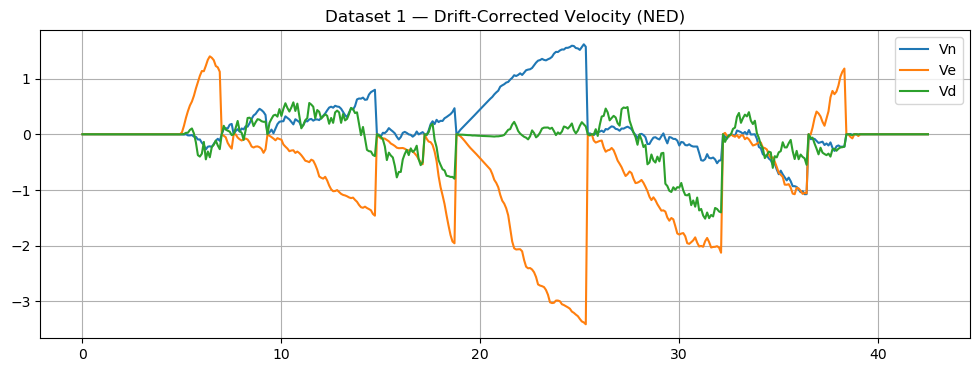

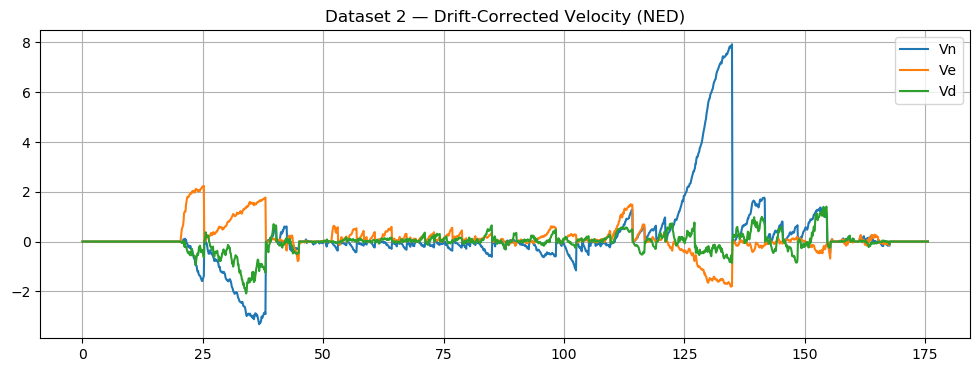

In [64]:
# Plot corrected velocity profiles
plt.figure(figsize=(12,4))
plt.plot(t1, vel1_corr)
plt.legend(['Vn','Ve','Vd'])
plt.title('Dataset 1 — Drift-Corrected Velocity (NED)')
plt.grid()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t2, vel2_corr)
plt.legend(['Vn','Ve','Vd'])
plt.title('Dataset 2 — Drift-Corrected Velocity (NED)')
plt.grid()
plt.show()

## Final Position Integration (After Drift-Corrected Velocity)

With drift-corrected velocity now available, we integrate again to obtain a
more stable and accurate estimate of the robot’s trajectory.  
This produces:

- Corrected position trajectory in the NED frame  
- Final displacement magnitude  
- Greatly reduced drift in comparison to uncorrected dead reckoning

In [66]:
# Compute corrected position for both datasets
pos1_corr = integrate_position_ned(vel1_corr, dt1)
pos2_corr = integrate_position_ned(vel2_corr, dt2)

# Final corrected displacement
print(f"Dataset 1: Corrected displacement (NED): {pos1_corr[-1]} | magnitude = {np.linalg.norm(pos1_corr[-1])} m")
print(f"Dataset 2: Corrected displacement (NED): {pos2_corr[-1]} | magnitude = {np.linalg.norm(pos2_corr[-1])} m")

Dataset 1: Corrected displacement (NED): [  6.4474222  -25.46000542  -4.14302929] | magnitude = 26.58845276447477 m
Dataset 2: Corrected displacement (NED): [36.76029244 19.45084241 -5.00187773] | magnitude = 41.888818931190364 m


## 2D Trajectory Visualization (NED -> East/North)

The reconstructed robot trajectory is visualized in the horizontal plane
using the corrected NED positions:

- **North = NED X**  
- **East = NED Y**  
- Plotting East (horizontal) vs North (vertical) gives a map-like view  
- Start and End positions are marked

In [73]:
def plot_2d_trajectory_ned(position_ned, title, color='b'):
    '''
        Plot 2D horizontal-plane trajectory using NED position data.

        Parameters:
            position_ned : ndarray (Nx3)
                Corrected position in NED frame. 
                NED axes: [North, East, Down].

            title : str
                Plot title.

            color : str
                Line color for trajectory.

        For visualization:
            - X-axis  = East  (NED Y)
            - Y-axis  = North (NED X)
        This gives a standard map-like orientation.
    '''
    north = position_ned[:, 0]   # NED X
    east  = position_ned[:, 1]   # NED Y

    plt.figure(figsize=(6,6))
    plt.plot(east, north, '-', color=color, label='Trajectory')
    plt.scatter(east[0], north[0], c='g', label="Start")
    plt.scatter(east[-1], north[-1], c='r', label="End")

    plt.title(title)
    plt.xlabel("East (m)")
    plt.ylabel("North (m)")
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Start Position (NED): North= {north[0]:.2f} m, East= {east[0]:.2f} m")
    print(f"End Position   (NED): North= {north[-1]:.2f} m, East= {east[-1]:.2f} m")
    print(f"Total Displacement  : {np.linalg.norm(position_ned[-1] - position_ned[0]):.2f} m\n")

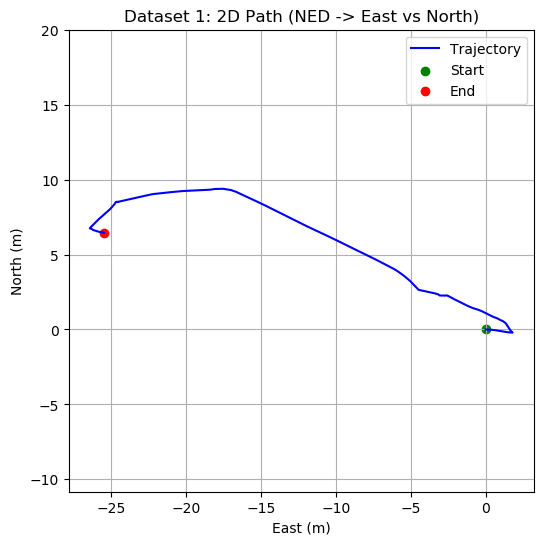

Start Position (NED): North= 0.00 m, East= 0.00 m
End Position   (NED): North= 6.45 m, East= -25.46 m
Total Displacement  : 26.59 m



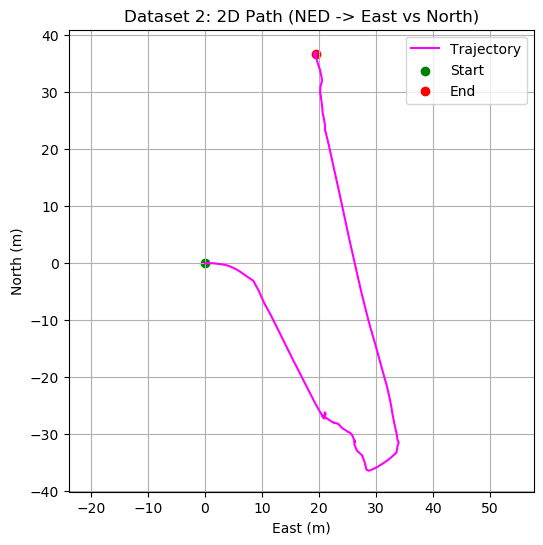

Start Position (NED): North= 0.00 m, East= 0.00 m
End Position   (NED): North= 36.76 m, East= 19.45 m
Total Displacement  : 41.89 m



In [74]:
# Plot corrected trajectories for both datasets
plot_2d_trajectory_ned(pos1_corr, title="Dataset 1: 2D Path (NED -> East vs North)", color='blue')
plot_2d_trajectory_ned(pos2_corr, title="Dataset 2: 2D Path (NED -> East vs North)", color='magenta')